<a href="https://colab.research.google.com/github/vijjus/CV/blob/master/denoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
load_weights = True
weights_file = "/content/gdrive/MyDrive/BinUNet_v2.pth"

In [2]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,784 kB/s)
Selecting previously unselect

In [3]:
! pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=88d789880de7ca5d282b566f402515300d38ee5ed13992aa9f179e4400c7dee3
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


In [4]:
import pytesseract
import numpy as np
import pandas as pd
import seaborn as sns
import random
import zipfile, os, cv2
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.nn import MSELoss
import torch.optim as optim
from glob import glob
import imgaug as ia
import matplotlib.pyplot as plt
import albumentations as A
import torch.nn.functional as F
from torchvision import transforms
from imgaug import augmenters as iaa
from albumentations.pytorch import ToTensor

sns.set_style('darkgrid')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [7]:
pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/pytesseract'

In [8]:
!cp /content/gdrive/MyDrive/bindata.tgz .
!ls

bindata.tgz  gdrive  sample_data


In [9]:
!tar -zxf bindata.tgz
!ls

bindata.tgz  datagen  gdrive  sample_data


In [10]:
!ls -l datagen/originals/ | wc -l

2220


In [11]:
!ls -l datagen/cleaned/ | wc -l

2220


# Data Preparation

In [12]:
train_num = int(len(os.listdir('datagen/cleaned/')) * 0.8)
train_num

1775

In [13]:
total_noisy_imgs = glob('datagen/originals/*.png')
print(len(total_noisy_imgs))

2219


In [14]:
total_cleaned_imgs = glob('datagen/cleaned/*.png')
print(len(total_cleaned_imgs))

2219


In [15]:
train_indices = random.sample(range(0, len(total_noisy_imgs)), train_num)
len(train_indices)

1775

In [16]:
train_img = []
train_cleaned_img = []
test_img = []
test_cleaned_img = []
for k in range(len(total_noisy_imgs)):
  if k in train_indices:
    train_img.append(total_noisy_imgs[k])
    train_cleaned_img.append(total_cleaned_imgs[k])
  else:
    test_img.append(total_noisy_imgs[k])
    test_cleaned_img.append(total_cleaned_imgs[k])
print(len(train_img), len(train_cleaned_img), len(test_img))

1775 1775 444


In [17]:
for k in range(5):
  j = random.randint(0, len(train_img))
  print(train_img[j], train_cleaned_img[j])

datagen/originals/20_cubanc_35_1_01281452ta_12.png datagen/cleaned/20_cubanc_35_1_01281452ta_12.png
datagen/originals/3.1_cubanc_35_1_01281452ta_12.png datagen/cleaned/3.1_cubanc_35_1_01281452ta_12.png
datagen/originals/3_cubanc_35_1_01281452ta_61.png datagen/cleaned/3_cubanc_35_1_01281452ta_61.png
datagen/originals/5.3_cubanc_35_1_01281452ta_74.png datagen/cleaned/5.3_cubanc_35_1_01281452ta_74.png
datagen/originals/5.2_cubanc_35_1_01281452ta_70.png datagen/cleaned/5.2_cubanc_35_1_01281452ta_70.png


In [18]:
train_img[0], train_cleaned_img[0], test_img[0], test_cleaned_img[0]  

('datagen/originals/5a.2_cubanc_35_1_01281452ta_95.png',
 'datagen/cleaned/5a.2_cubanc_35_1_01281452ta_95.png',
 'datagen/originals/3_cubanc_35_1_01281452ta_43.png',
 'datagen/cleaned/3_cubanc_35_1_01281452ta_43.png')

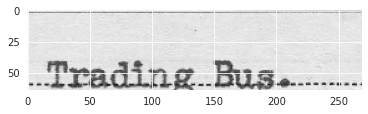

In [19]:
img = cv2.imread(train_img[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

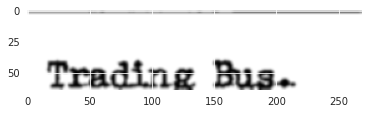

In [20]:
img = cv2.imread(train_cleaned_img[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

In [21]:
imgs = [cv2.imread(f) for f in train_img]
print('Median Dimensions:', np.median([len(img) for img in imgs]), np.median([len(img[0]) for img in imgs]))
del imgs

Median Dimensions: 63.0 350.0


In [22]:
IMG_SIZE = (64, 600)

In [23]:
def resize_image(image):
    if isinstance(image, str):
      image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    scale_coef = float(IMG_SIZE[0]) / image.shape[0]
    new_width = int(image.shape[1] * scale_coef)

    if new_width > IMG_SIZE[1]:
        # TODO this is a hack
        resized_image = cv2.resize(
            image, (IMG_SIZE[1], IMG_SIZE[0]), cv2.INTER_AREA
        )

        return np.reshape(resized_image, ((*IMG_SIZE, 1)))

    new_height = IMG_SIZE[0]
    resized_image = cv2.resize(image, (new_width, new_height), cv2.INTER_CUBIC)

    padded_image = np.full(IMG_SIZE, 255, dtype=image.dtype)

    padded_image[
        : resized_image.shape[0], : resized_image.shape[1]
    ] = resized_image

    padded_image = np.reshape(padded_image, (*IMG_SIZE, 1))
    return padded_image

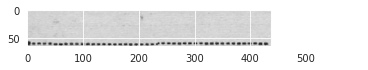

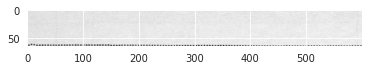

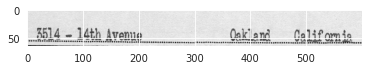

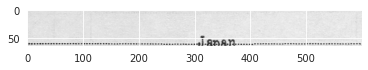

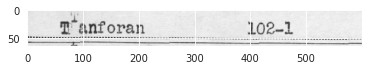

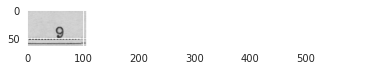

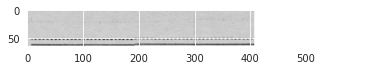

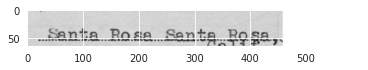

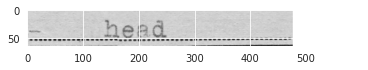

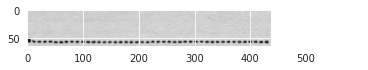

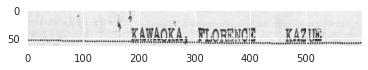

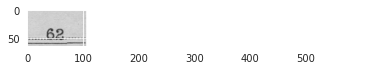

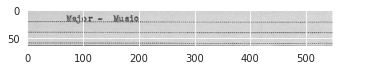

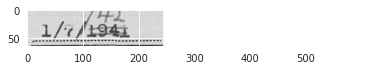

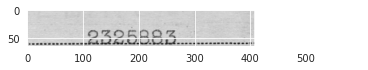

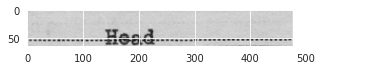

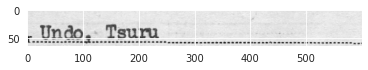

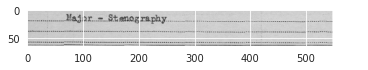

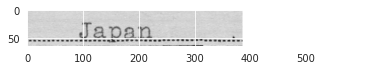

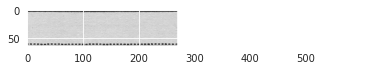

In [24]:
for k in range(20):
  j = random.randint(0, len(train_img))
  img = cv2.imread(train_img[j], cv2.IMREAD_GRAYSCALE)
  img = resize_image(img)
  plt.imshow(img.reshape(*IMG_SIZE), cmap='gray')
  plt.show()

In [25]:
train = []
train_cleaned = []
test = []
test_cleaned = []
for f in train_img:
    train.append(resize_image(f))

for f in train_cleaned_img:
    train_cleaned.append(resize_image(f))
    
for f in test_img:
    test.append(resize_image(f))

for f in test_cleaned_img:
    test_cleaned.append(resize_image(f))
    
train = np.asarray(train, dtype=np.float32)
train_cleaned = np.asarray(train_cleaned, dtype=np.float32)
test = np.asarray(test, dtype=np.float32)
test_cleaned = np.asarray(test_cleaned, dtype=np.float32)

In [26]:
train.shape, train_cleaned.shape, test.shape, test_cleaned.shape

((1775, 64, 600, 1), (1775, 64, 600, 1), (444, 64, 600, 1), (444, 64, 600, 1))

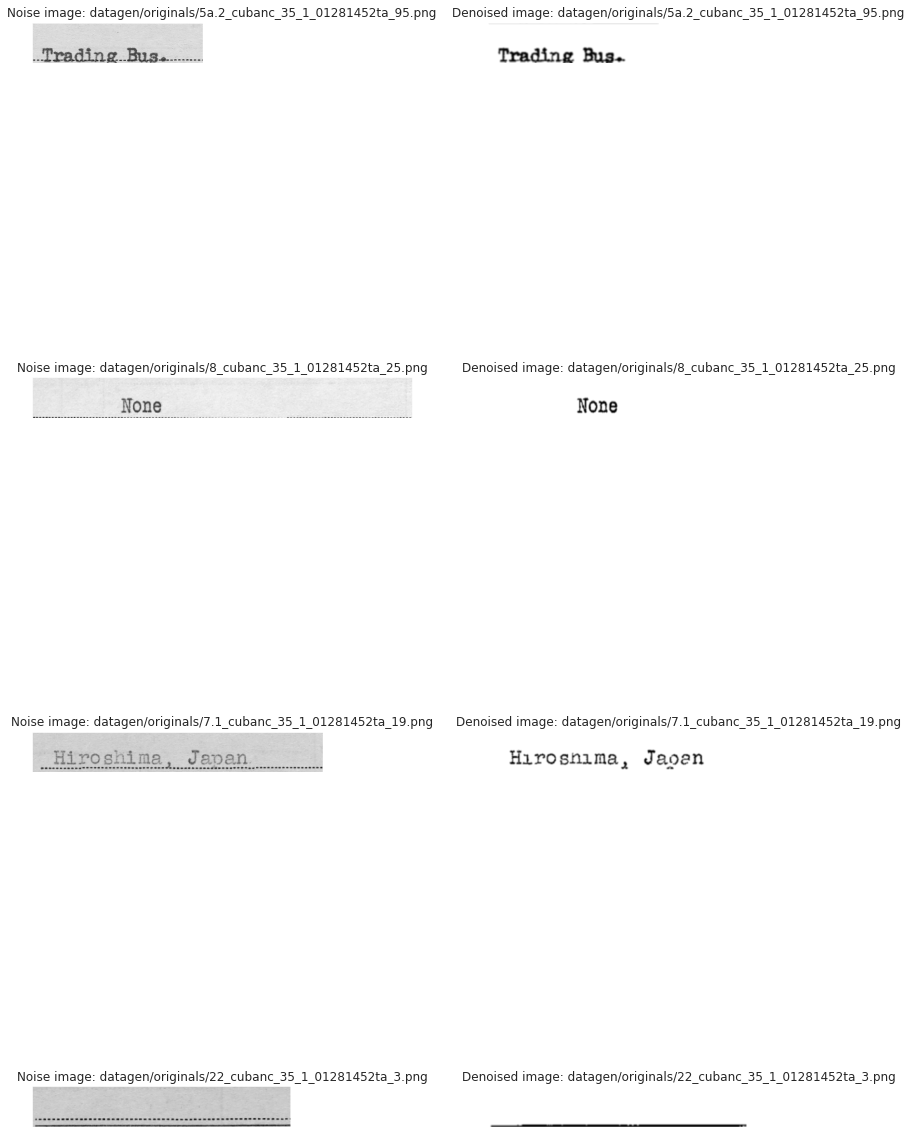

In [27]:
fig, ax = plt.subplots(4, 2, figsize=(15,25))
for i in range(4):
    ax[i][0].imshow(np.squeeze(train[i]), cmap='gray')
    ax[i][0].set_title('Noise image: {}'.format(train_img[i]))
    
    ax[i][1].imshow(np.squeeze(train_cleaned[i]), cmap='gray')
    ax[i][1].set_title('Denoised image: {}'.format(train_img[i]))
    
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].get_yaxis().set_visible(False)
    ax[i][1].get_xaxis().set_visible(False)
    ax[i][1].get_yaxis().set_visible(False)

In [28]:
def augment_pipeline(pipeline, images, seed=53):
    ia.seed(seed)
    processed_images = images.copy()
    for step in pipeline:
        temp = np.array(step.augment_images(images), dtype=np.float32)
        processed_images = np.append(processed_images, temp, axis=0)
    return(processed_images)

In [29]:
rotate90 = iaa.Rot90(1) # rotate image 90 degrees
rotate180 = iaa.Rot90(2) # rotate image 180 degrees
rotate270 = iaa.Rot90(3) # rotate image 270 degrees
random_rotate = iaa.Rot90((1,3)) # randomly rotate image from 90,180,270 degrees
perc_transform = iaa.PerspectiveTransform(scale=(0.02, 0.1)) # Skews and transform images without black bg
rotate10 = iaa.Affine(rotate=(10)) # rotate image 10 degrees
rotate10r = iaa.Affine(rotate=(-10)) # rotate image 30 degrees in reverse
crop = iaa.Crop(px=(5, 32)) # Crop between 5 to 32 pixels
hflip = iaa.Fliplr(1) # horizontal flips for 100% of images
vflip = iaa.Flipud(1) # vertical flips for 100% of images
gblur = iaa.GaussianBlur(sigma=(1, 1.5)) # gaussian blur images with a sigma of 1.0 to 1.5
motionblur = iaa.MotionBlur(8) # motion blur images with a kernel size 8

seq_rp = iaa.Sequential([
    iaa.Rot90((1,3)), # randomly rotate image from 90,180,270 degrees
    iaa.PerspectiveTransform(scale=(0.02, 0.1)) # Skews and transform images without black bg
])

seq_cfg = iaa.Sequential([
    iaa.Crop(px=(5, 32)), # crop images from each side by 5 to 32px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 1.5)) # blur images with a sigma of 0 to 1.5
])

seq_fm = iaa.Sequential([
    iaa.Flipud(1), # vertical flips all the images
    iaa.MotionBlur(k=6) # motion blur images with a kernel size 6
])

In [30]:
pipeline = [
    rotate90, rotate180, rotate270, hflip, vflip
]

In [31]:
processed_train = augment_pipeline(pipeline, train)
processed_train_cleaned = augment_pipeline(pipeline, train_cleaned)

processed_train.shape, processed_train_cleaned.shape

((10650, 64, 600, 1), (10650, 64, 600, 1))

In [32]:
type(processed_train[0][0][0][0])

numpy.float32

https://openaccess.thecvf.com/content_CVPRW_2020/papers/w22/Beheshti_Squeeze_U-Net_A_Memory_and_Energy_Efficient_Image_Segmentation_Network_CVPRW_2020_paper.pdf

In [33]:
""" Parts of the U-Net model """

class SEDown(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.in_conv = nn.Conv2d(in_channels, in_channels//2, kernel_size=1)
    self.conv1 = nn.Conv2d(in_channels//2, out_channels//2, kernel_size=1, stride=2)
    self.conv2 = nn.Conv2d(in_channels//2, out_channels//2, kernel_size=3, stride=2, padding=1)

  def forward(self, x):
    # 1x1 + ReLU (inC -> inC//2)
    x = self.in_conv(x)
    x = F.relu(x, inplace=True)
    # 1x1 + Relu (inC//2 -> outC//2)
    x1 = self.conv1(x)
    x1 = F.relu(x1, inplace=True)
    # 2x2 + Relu (inC//2 -> outC//2)
    x2 = self.conv2(x)
    x2 = F.relu(x2, inplace=True)
    # print(x1.shape, x2.shape)
    # contatinate the outputs to produce outC channels
    return torch.cat([x1, x2], dim=1)

class SEUp(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.in_conv = nn.ConvTranspose2d(in_channels, in_channels//4, kernel_size=1)
    self.conv1 = nn.ConvTranspose2d(in_channels//4, out_channels//2, kernel_size=1, stride=2)
    self.conv2 = nn.ConvTranspose2d(in_channels//4, out_channels//2, kernel_size=2, stride=2, padding=1)

  def forward(self, x, r):
    print(x.shape, r.shape)
    
    # cat the residual from the Down layer, pad to match shapes
    diffY = r.size()[2] - x.size()[2]
    diffX = r.size()[3] - x.size()[3]

    x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
    # if you have padding issues, see
    # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
    # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
    
    x = torch.cat([r, x], dim=1)

    # 1x1 + ReLU (inC -> inC//4)
    x = self.in_conv(x)
    x = F.relu(x, inplace=True)
    # 1x1 + Relu (inC//4 -> outC//2)
    x1 = self.conv1(x)
    x1 = F.relu(x1, inplace=True)
    # 3x3 + Relu (inC//4 -> outC//2)
    x2 = self.conv2(x)
    x2 = F.relu(x2, inplace=True)

    print(x1.shape, x2.shape)
    x1 = F.pad(x2, (1, 0, 1, 0), "constant", 0)
    # contatinate the outputs to produce outC channels
    return torch.cat([x1, x2], dim=1)

class DoubleConv(nn.Module):
  """(convolution => [BN] => ReLU) * 2"""

  def __init__(self, in_channels, out_channels, mid_channels=None):
      super().__init__()
      if not mid_channels:
          mid_channels = out_channels
      self.double_conv = nn.Sequential(
          nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
          nn.BatchNorm2d(mid_channels),
          nn.ReLU(inplace=True),
          nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
      )

  def forward(self, x):
      return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [34]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [35]:
unet = UNet(1, 1)
if load_weights:
  unet.load_state_dict(torch.load(weights_file))
unet = unet.to(device)

In [36]:
inp = torch.randn((8,1,100,100))
out = unet(inp.to(device))
out.shape

torch.Size([8, 1, 100, 100])

In [37]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params / 1000000

In [38]:
print(f"Model has {count_parameters(unet):.2f}M parameters")

Model has 17.27M parameters


In [39]:
# the images are already numpy arrays, and augmentation has
# already been applied
class DenoiseDS(torch.utils.data.Dataset):
  def __init__(self, images, cleaned_images=None, x_transforms=None, y_transforms=None):
    self.images = images
    self.gt = cleaned_images
    self.x_transforms = x_transforms
    self.y_transforms = y_transforms

  def __len__(self):
    return self.images.shape[0]

  def __getitem__(self, index):
    x = self.images[index]
    #print(type(x))
    if self.gt is not None:
      y = self.gt[index]
    else:
      y = None

    # both the input and cleaned image need the same transform
    if self.x_transforms is not None:
      x = self.x_transforms(image=x)['image']
    if y is not None and self.y_transforms is not None:
        y = self.y_transforms(image=y)['image']

    return (x, y)


In [40]:
train_transform_x = A.Compose([
  #A.OneOf([
  #    A.IAAAdditiveGaussianNoise(scale=(0, 0.001 * 255), p=0.5),
  #    A.GaussNoise(var_limit=(5, 5)),
  #], p=0.3),
  A.OneOf([
      A.MotionBlur(blur_limit=3, p=0.2),
      A.MedianBlur(blur_limit=3, p=0.1),
      A.Blur(blur_limit=3, p=0.1),
  ], p=0.5),
  A.OneOf([
      A.OpticalDistortion(distort_limit=0.001, shift_limit=0.001, p=0.3),
      A.GridDistortion(distort_limit=0.01, p=0.1),
      A.IAAPiecewiseAffine(scale=(0.01, 0.02), p=0.3),
  ], p=0.5),
  #A.OneOf([
  #    A.CLAHE(clip_limit=2),
  #    A.IAASharpen(),
  #    A.IAAEmboss(),
  #    A.RandomBrightnessContrast(),            
  #], p=0.3),                            
  A.Normalize(mean=[0.5], std=[0.5]),
  ToTensor(),
])

In [41]:
train_transform_y = A.Compose([
  A.Normalize(mean=[0.5], std=[0.5]),
  ToTensor(),
])

In [42]:
train_ds = DenoiseDS(images=processed_train, cleaned_images=processed_train_cleaned, x_transforms=train_transform_x, y_transforms=train_transform_y)

In [43]:
train_iter = iter(train_ds)

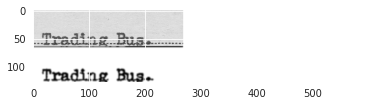

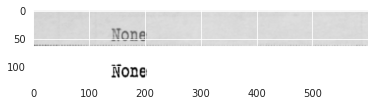

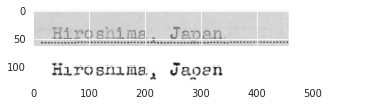

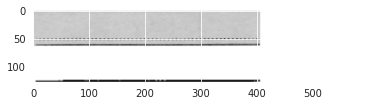

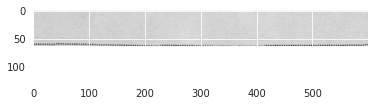

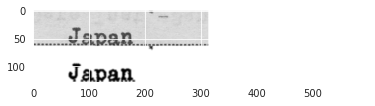

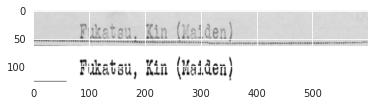

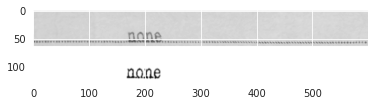

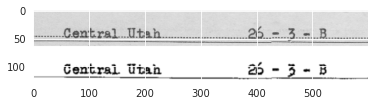

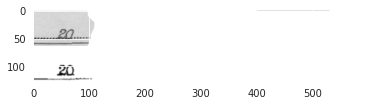

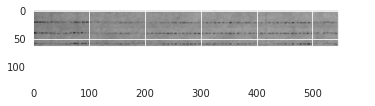

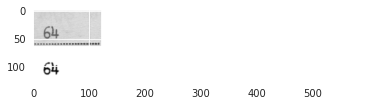

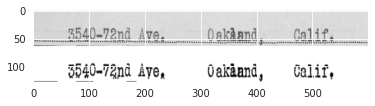

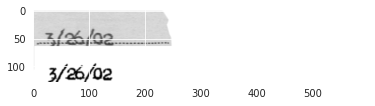

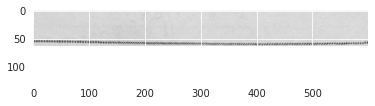

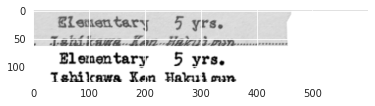

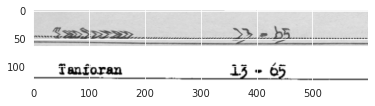

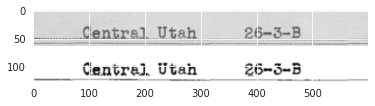

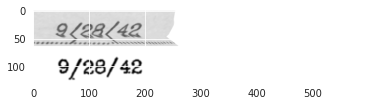

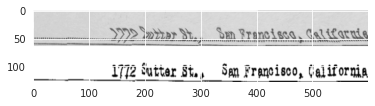

In [44]:
for k in range(20):
  data = next(train_iter)
  x, y = data
  img = torch.cat([x.squeeze(0), y.squeeze(0)], axis=0)
  plt.imshow(img, cmap='gray')
  plt.show()

In [45]:
test_transform = A.Compose([
  A.Normalize(mean=[0.5], std=[0.5]),
  ToTensor(),
])

In [46]:
test_ds = DenoiseDS(images=test, cleaned_images=test_cleaned, x_transforms=test_transform, y_transforms=test_transform)

In [47]:
criterion = MSELoss(reduction='sum')
optimizer = optim.Adam(unet.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [48]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=8, shuffle=False)

In [49]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

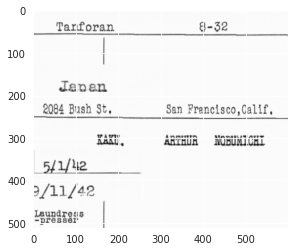


Epoch 0: train loss 13937.53, val loss 1329.86
Validation loss decreased (inf --> 1329.855238).  Saving model ...


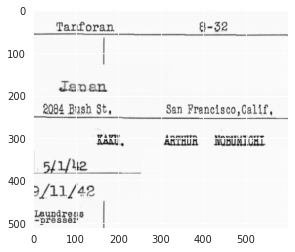


Epoch 1: train loss 13479.68, val loss 1234.85
Validation loss decreased (1329.855238 --> 1234.853825).  Saving model ...


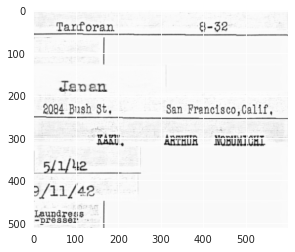


Epoch 2: train loss 13410.03, val loss 1795.70
EarlyStopping counter: 1 out of 10


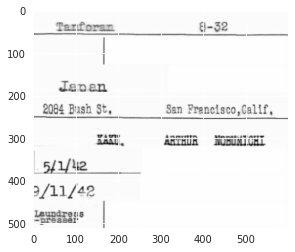


Epoch 3: train loss 12936.34, val loss 2404.36
EarlyStopping counter: 2 out of 10


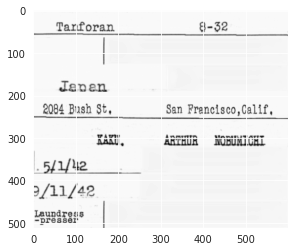


Epoch 4: train loss 13106.65, val loss 1353.69
EarlyStopping counter: 3 out of 10


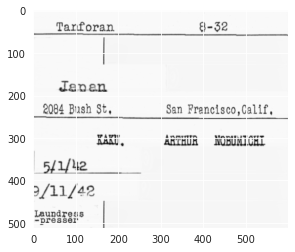


Epoch 5: train loss 13173.34, val loss 1222.93
Validation loss decreased (1234.853825 --> 1222.930066).  Saving model ...


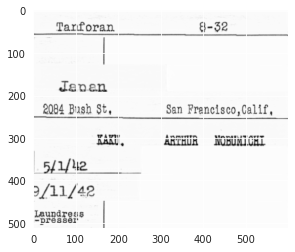


Epoch 6: train loss 12611.38, val loss 1426.13
EarlyStopping counter: 1 out of 10


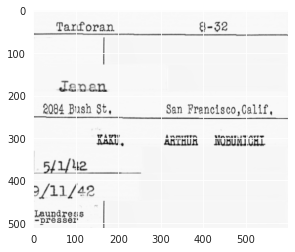


Epoch 7: train loss 12436.54, val loss 1156.43
Validation loss decreased (1222.930066 --> 1156.430406).  Saving model ...


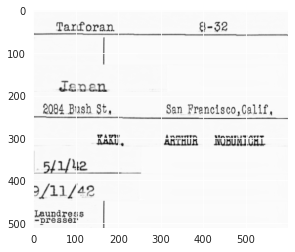


Epoch 8: train loss 12872.86, val loss 1223.30
EarlyStopping counter: 1 out of 10


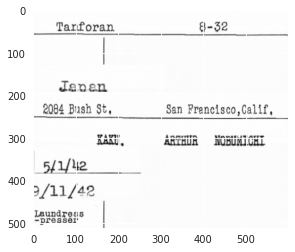


Epoch 9: train loss 12572.76, val loss 1080.82
Validation loss decreased (1156.430406 --> 1080.817933).  Saving model ...


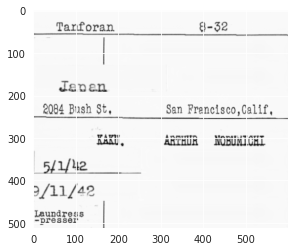


Epoch 10: train loss 12653.08, val loss 1326.71
EarlyStopping counter: 1 out of 10


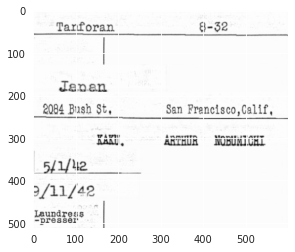


Epoch 11: train loss 12388.58, val loss 1527.28
EarlyStopping counter: 2 out of 10


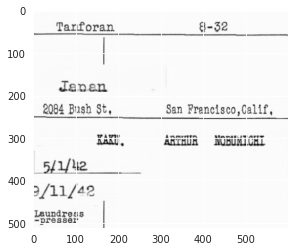


Epoch 12: train loss 12304.27, val loss 1170.05
EarlyStopping counter: 3 out of 10


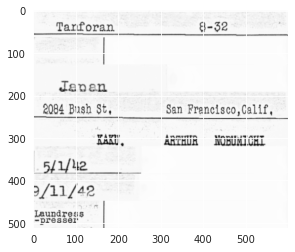


Epoch 13: train loss 12288.94, val loss 1721.36
Epoch    14: reducing learning rate of group 0 to 1.0000e-03.
EarlyStopping counter: 4 out of 10


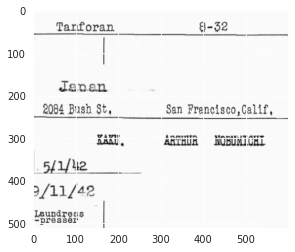


Epoch 14: train loss 11680.73, val loss 984.19
Validation loss decreased (1080.817933 --> 984.191648).  Saving model ...


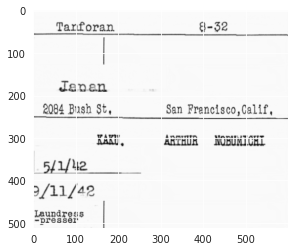


Epoch 15: train loss 11504.80, val loss 973.78
Validation loss decreased (984.191648 --> 973.781064).  Saving model ...


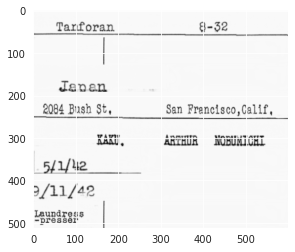


Epoch 16: train loss 11301.86, val loss 1063.97
EarlyStopping counter: 1 out of 10


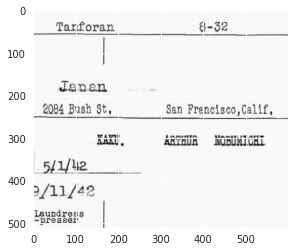


Epoch 17: train loss 11120.38, val loss 1016.11
EarlyStopping counter: 2 out of 10


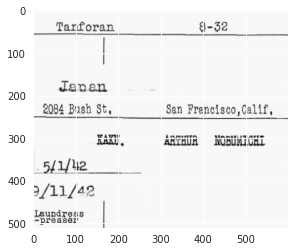


Epoch 18: train loss 11145.78, val loss 979.27
EarlyStopping counter: 3 out of 10


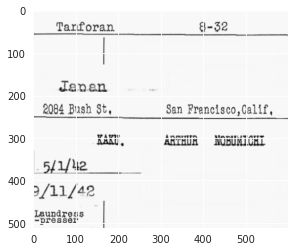


Epoch 19: train loss 11082.08, val loss 979.94
Epoch    20: reducing learning rate of group 0 to 1.0000e-04.
EarlyStopping counter: 4 out of 10


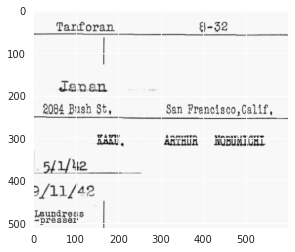


Epoch 20: train loss 11231.32, val loss 967.11
Validation loss decreased (973.781064 --> 967.113697).  Saving model ...


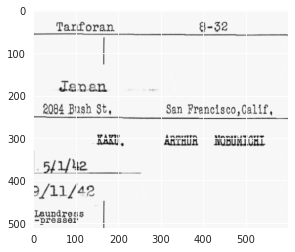


Epoch 21: train loss 11102.78, val loss 963.33
Validation loss decreased (967.113697 --> 963.330341).  Saving model ...


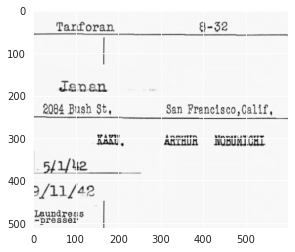


Epoch 22: train loss 10896.36, val loss 972.05
EarlyStopping counter: 1 out of 10


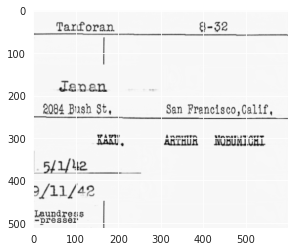


Epoch 23: train loss 10949.36, val loss 961.16
Validation loss decreased (963.330341 --> 961.160028).  Saving model ...


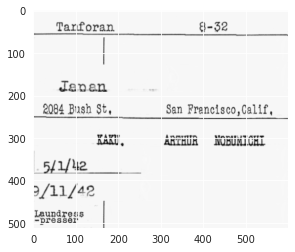


Epoch 24: train loss 11023.01, val loss 966.51
EarlyStopping counter: 1 out of 10


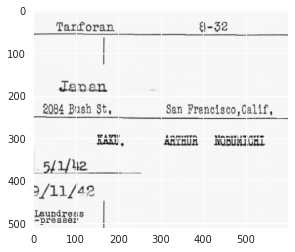


Epoch 25: train loss 10872.24, val loss 973.39
EarlyStopping counter: 2 out of 10


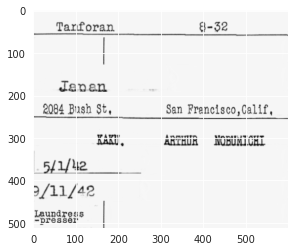


Epoch 26: train loss 10939.81, val loss 982.38
EarlyStopping counter: 3 out of 10


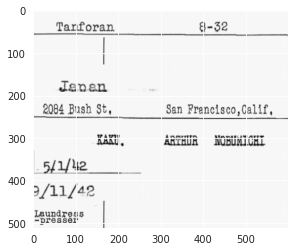


Epoch 27: train loss 11018.97, val loss 965.72
Epoch    28: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 4 out of 10


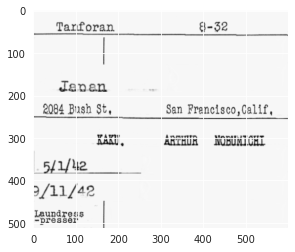


Epoch 28: train loss 10923.34, val loss 968.73
EarlyStopping counter: 5 out of 10


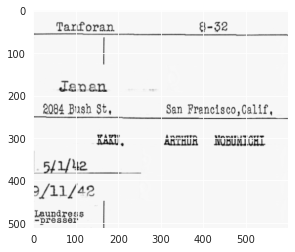


Epoch 29: train loss 10809.98, val loss 958.54
Validation loss decreased (961.160028 --> 958.536067).  Saving model ...


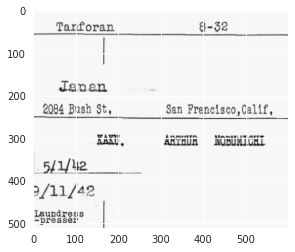


Epoch 30: train loss 11058.54, val loss 970.31
EarlyStopping counter: 1 out of 10


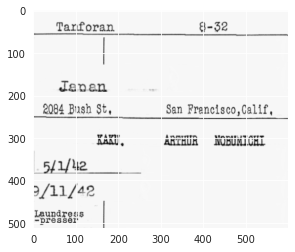


Epoch 31: train loss 10880.57, val loss 969.99
EarlyStopping counter: 2 out of 10


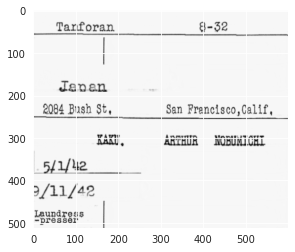


Epoch 32: train loss 10923.07, val loss 965.92
EarlyStopping counter: 3 out of 10


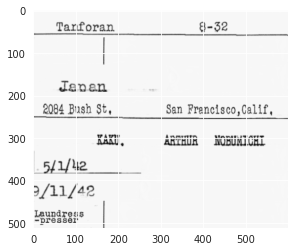


Epoch 33: train loss 10829.30, val loss 973.29
Epoch    34: reducing learning rate of group 0 to 1.0000e-06.
EarlyStopping counter: 4 out of 10


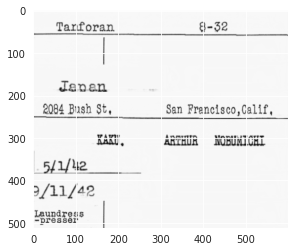


Epoch 34: train loss 10886.08, val loss 974.21
EarlyStopping counter: 5 out of 10


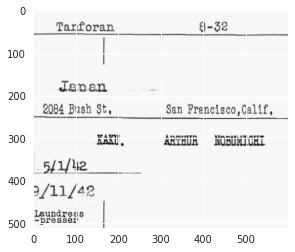


Epoch 35: train loss 11185.44, val loss 971.64
EarlyStopping counter: 6 out of 10


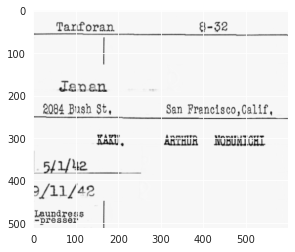


Epoch 36: train loss 10909.42, val loss 968.53
EarlyStopping counter: 7 out of 10


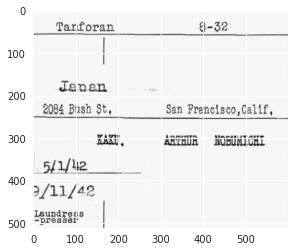


Epoch 37: train loss 11003.21, val loss 979.64
Epoch    38: reducing learning rate of group 0 to 1.0000e-07.
EarlyStopping counter: 8 out of 10


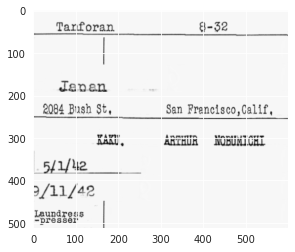


Epoch 38: train loss 10930.65, val loss 964.26
EarlyStopping counter: 9 out of 10


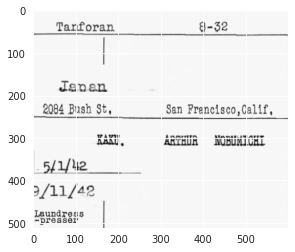


Epoch 39: train loss 10804.55, val loss 1003.92
EarlyStopping counter: 10 out of 10
Early stopping, loading best weight.. , val loss=-958.54


In [50]:
num_epochs = 100
num_show = 5
early_stopping = EarlyStopping(verbose=True, path=weights_file, patience=10)

for epoch in range(num_epochs):
  train_losses = []
  valid_losses = []
  unet.train()
  for data in tqdm(train_loader):
    x, y = data

    optimizer.zero_grad()

    x = x.float()
    y = y.float()
    output = unet(x.to(device))

    loss = criterion(output, y.to(device))

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

  unet.eval()
  show=True
  for data in tqdm(test_loader):
    x, y = data

    x = x.float()
    y = y.float()

    with torch.no_grad():
      output = unet(x.to(device))

    if show:
        img = torch.cat([x.cpu().squeeze(0) for x in output], dim=0)
        plt.imshow(img, cmap='gray')
        plt.show()
        show=False

    loss = criterion(output, y.to(device))

    valid_losses.append(loss.item())

  train_loss = np.average(train_losses)
  val_loss = np.average(valid_losses)
  print(f'Epoch {epoch}: train loss {train_loss:.2f}, val loss {val_loss:.2f}')

  scheduler.step(val_loss)
  
  early_stopping(val_loss, unet)

  if early_stopping.early_stop:
    print(f"Early stopping, loading best weight.. , val loss={early_stopping.best_score:.2f}")
    unet.load_state_dict(torch.load(early_stopping.path))
    break

In [ ]:
test_ds = DenoiseDS(images=test, x_transforms=test_transform)

In [ ]:
test_iter = iter(test_ds)

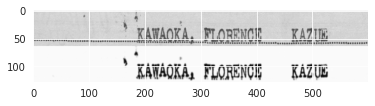

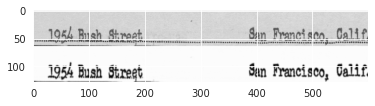

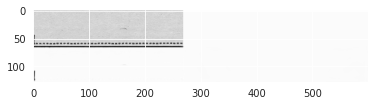

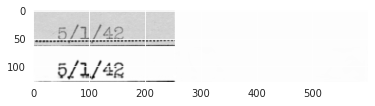

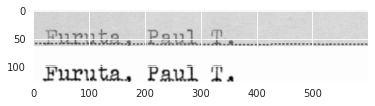

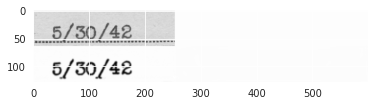

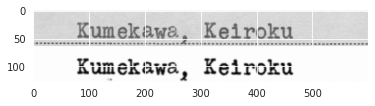

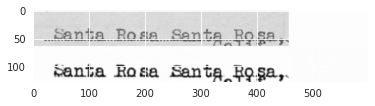

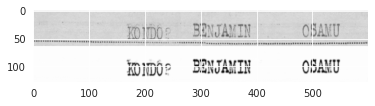

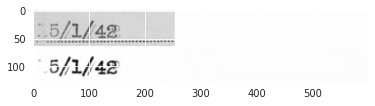

In [ ]:
for _ in range(10):
  data = next(test_iter)
  x, _ = data

  x = x.float()

  with torch.no_grad():
    out = unet(x.unsqueeze(0).to(device))

  out = out.cpu()
  d = torch.cat([x.reshape(IMG_SIZE), out.reshape(IMG_SIZE)], dim=0)
  plt.imshow(d, cmap='gray')
  plt.show()

In [ ]:
torch.save(unet.state_dict(), "/content/gdrive/MyDrive/BinUNet_v2.pth")